# Support Vector Machines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
Mix = pd.read_csv('Mix.csv', sep=',', index_col=0)
Mix.head()

,X1,X2,Y
1,2.526093,0.321050,-1
2,0.366954,0.031462,-1
3,0.768219,0.717486,-1
4,0.693436,0.777194,-1
5,-0.019837,0.867254,-1


In [3]:
Mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 3 columns):
X1    200 non-null float64
X2    200 non-null float64
Y     200 non-null int64
dtypes: float64(2), int64(1)
memory usage: 6.2 KB


In [4]:
Mix.describe()

,X1,X2,Y
count,200.000000,200.000000,200.000000
mean,0.784672,0.756016,0.000000
std,1.297582,1.026442,1.002509
min,-2.520820,-1.999853,-1.000000
25%,-0.071465,0.095555,-1.000000
50%,0.859702,0.861387,0.000000
75%,1.543438,1.435275,1.000000
max,4.170746,2.855805,1.000000


In [5]:
X = Mix.loc[:,['X1','X2']].values
Y = Mix.loc[:,['Y']].values

X_train = Mix.loc[:,['X1','X2']].values[:160,:]
Y_train = Mix.loc[:,['Y']].values[:160,:]

X_test = Mix.loc[:,['X1','X2']].values[160:,:]
Y_test = Mix.loc[:,['Y']].values[160:,:]

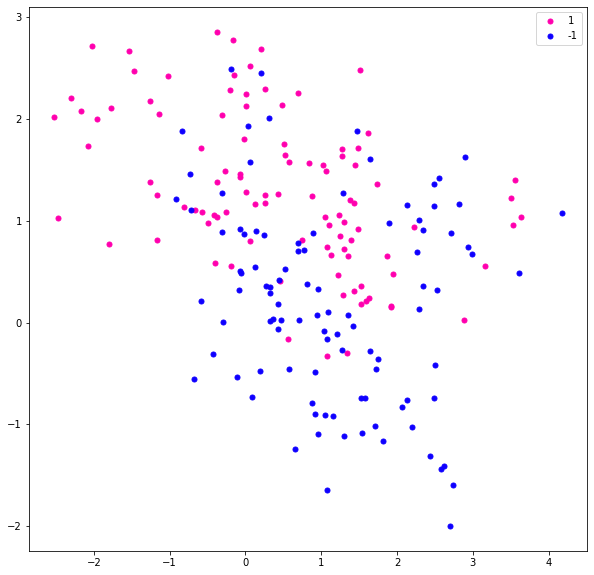

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == -1)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='-1') 
ax.legend()

In [7]:
class Layer1():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.delta = 0.5
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.l = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.weights = [self.l]

    def __call__(self, inputs):
        m = tf.shape(inputs)[0]
        u = tf.repeat(tf.expand_dims(tf.transpose(self.l), axis=0), repeats=m, axis=0)
        x = tf.repeat(tf.expand_dims(inputs, axis=2), repeats=self.output_dim, axis=2)
        z = tf.reduce_sum(tf.square(x-u), axis=1)
        return tf.exp(-z/(2*tf.square(self.delta)))
    
class Layer3():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        return tf.transpose(z)
    
class Layer4():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
            
    def build(self): 
        self.weights = []

    def __call__(self, inputs):
        return 2.*tf.sign(1.+tf.sign(inputs))-1.

In [8]:
class LossFunction():
        
    def __init__(self, model, C, p):
        self.model = model
        self.C = C
        self.p = p
            
    def __call__(self, y_true, y_pred):
        loss = tf.reduce_sum(tf.maximum(0.,1.-y_true*y_pred))
        regularization = tf.reduce_sum(tf.math.pow(tf.math.abs(self.model.weights[1]), self.p))
        return self.C*loss + regularization 

In [9]:
class MetricFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        y_pred_ = self.model.h4(y_pred)
        return tf.math.reduce_mean(1.-tf.square(tf.sign(y_true-y_pred_)))

In [10]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [11]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [12]:
class SVM():
    
    def __init__(self, input_dim, kernel_dim, output_dim):
        self.input_dim = input_dim
        self.kernel_dim = kernel_dim
        self.output_dim = output_dim
        self.build()
     
    def build(self):
        self.h1 = Layer1(input_dim=self.input_dim, output_dim=self.input_dim)
        self.h2 = Layer2(input_dim=self.input_dim, output_dim=self.kernel_dim)
        self.h3 = Layer3(input_dim=self.kernel_dim, output_dim=self.output_dim)
        self.h4 = Layer4(input_dim=self.output_dim, output_dim=self.output_dim)
        self.layers = [self.h1, self.h2, self.h3, self.h4]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):        
        a1 = self.h1(inputs)
        a2 = self.h2(a1)
        y = self.h3(a2)
        return y 
        
    def train_setup(self, epochs, learning_rate, p, C, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.p = p
        self.C = C
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self, C=self.C, p=self.p)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon) 
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, epochs=10000, learning_rate=0.01, p=2, C=1.0, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, p, C, beta_1, beta_2, epsilon, verbose)
        if verbose:
            tf.print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self.h4(self(tf.constant(inputs, dtype="float32"))).numpy()
        
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [13]:
svm = SVM(input_dim=X_train.shape[1],
          kernel_dim=100,
          output_dim=Y_train.shape[1])

svm.fit(X_train, Y_train)

Train on 160 samples
Epochs 1/10000 - Loss: 149.76181030273438 - Metric: 0.6187499761581421
----- 0.072s -----
Epochs 2/10000 - Loss: 150.11782836914062 - Metric: 0.625
----- 0.012s -----
Epochs 3/10000 - Loss: 148.5657196044922 - Metric: 0.625
----- 0.016s -----
Epochs 4/10000 - Loss: 142.7058563232422 - Metric: 0.625
----- 0.024s -----
Epochs 5/10000 - Loss: 137.17279052734375 - Metric: 0.637499988079071
----- 0.026s -----
Epochs 6/10000 - Loss: 135.23175048828125 - Metric: 0.6875
----- 0.028s -----
Epochs 7/10000 - Loss: 130.56820678710938 - Metric: 0.6937500238418579
----- 0.017s -----
Epochs 8/10000 - Loss: 126.13533020019531 - Metric: 0.6812499761581421
----- 0.015s -----
Epochs 9/10000 - Loss: 122.303466796875 - Metric: 0.6812499761581421
----- 0.016s -----
Epochs 10/10000 - Loss: 119.0029525756836 - Metric: 0.6812499761581421
----- 0.019s -----
Epochs 11/10000 - Loss: 116.6937026977539 - Metric: 0.6875
----- 0.02s -----
Epochs 12/10000 - Loss: 115.34945678710938 - Metric: 0.693

Epochs 95/10000 - Loss: 92.10843658447266 - Metric: 0.7749999761581421
----- 0.012s -----
Epochs 96/10000 - Loss: 92.03948974609375 - Metric: 0.7749999761581421
----- 0.012s -----
Epochs 97/10000 - Loss: 91.97847747802734 - Metric: 0.7749999761581421
----- 0.012s -----
Epochs 98/10000 - Loss: 91.94335174560547 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 99/10000 - Loss: 91.88418579101562 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 100/10000 - Loss: 91.82465362548828 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 101/10000 - Loss: 91.7789077758789 - Metric: 0.7749999761581421
----- 0.013s -----
Epochs 102/10000 - Loss: 91.71968078613281 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 103/10000 - Loss: 91.66458129882812 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 104/10000 - Loss: 91.60662078857422 - Metric: 0.7749999761581421
----- 0.011s -----
Epochs 105/10000 - Loss: 91.55473327636719 - Metric: 0.7749999761581421
----- 0.011s -----
Epoch

----- 0.012s -----
Epochs 187/10000 - Loss: 80.60553741455078 - Metric: 0.793749988079071
----- 0.01s -----
Epochs 188/10000 - Loss: 80.06134033203125 - Metric: 0.800000011920929
----- 0.01s -----
Epochs 189/10000 - Loss: 79.9334487915039 - Metric: 0.800000011920929
----- 0.01s -----
Epochs 190/10000 - Loss: 79.77793884277344 - Metric: 0.800000011920929
----- 0.01s -----
Epochs 191/10000 - Loss: 79.32675170898438 - Metric: 0.8062499761581421
----- 0.009s -----
Epochs 192/10000 - Loss: 78.83220672607422 - Metric: 0.8125
----- 0.01s -----
Epochs 193/10000 - Loss: 78.61538696289062 - Metric: 0.8125
----- 0.01s -----
Epochs 194/10000 - Loss: 78.33914947509766 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 195/10000 - Loss: 77.8878173828125 - Metric: 0.8187500238418579
----- 0.009s -----
Epochs 196/10000 - Loss: 77.62272644042969 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 197/10000 - Loss: 77.4346694946289 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 198/10000 -

----- 0.01s -----
Epochs 279/10000 - Loss: 73.05266571044922 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 280/10000 - Loss: 73.05596923828125 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 281/10000 - Loss: 73.03289031982422 - Metric: 0.8187500238418579
----- 0.009s -----
Epochs 282/10000 - Loss: 73.00970458984375 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 283/10000 - Loss: 73.01134490966797 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 284/10000 - Loss: 73.00019073486328 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 285/10000 - Loss: 72.98261260986328 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 286/10000 - Loss: 72.95582580566406 - Metric: 0.8187500238418579
----- 0.009s -----
Epochs 287/10000 - Loss: 72.9425277709961 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 288/10000 - Loss: 72.94076538085938 - Metric: 0.8187500238418579
----- 0.01s -----
Epochs 289/10000 - Loss: 72.91901397705078 - Metric: 0.8187500238418579
----- 

----- 0.012s -----
Epochs 370/10000 - Loss: 71.54702758789062 - Metric: 0.8125
----- 0.012s -----
Epochs 371/10000 - Loss: 71.5197525024414 - Metric: 0.8125
----- 0.011s -----
Epochs 372/10000 - Loss: 71.51628112792969 - Metric: 0.8125
----- 0.011s -----
Epochs 373/10000 - Loss: 71.49006652832031 - Metric: 0.8125
----- 0.011s -----
Epochs 374/10000 - Loss: 71.49488067626953 - Metric: 0.8125
----- 0.012s -----
Epochs 375/10000 - Loss: 71.48086547851562 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 376/10000 - Loss: 71.46824645996094 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 377/10000 - Loss: 71.45465850830078 - Metric: 0.8125
----- 0.011s -----
Epochs 378/10000 - Loss: 71.43939208984375 - Metric: 0.8125
----- 0.012s -----
Epochs 379/10000 - Loss: 71.45664978027344 - Metric: 0.8125
----- 0.011s -----
Epochs 380/10000 - Loss: 71.42875671386719 - Metric: 0.8125
----- 0.011s -----
Epochs 381/10000 - Loss: 71.45787811279297 - Metric: 0.8125
----- 0.011s -----
Epochs 382

----- 0.011s -----
Epochs 466/10000 - Loss: 71.02789306640625 - Metric: 0.8187500238418579
----- 0.014s -----
Epochs 467/10000 - Loss: 71.02203369140625 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 468/10000 - Loss: 71.02732849121094 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 469/10000 - Loss: 71.01817321777344 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 470/10000 - Loss: 71.0505142211914 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 471/10000 - Loss: 71.00926208496094 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 472/10000 - Loss: 71.00825500488281 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 473/10000 - Loss: 70.99967193603516 - Metric: 0.8187500238418579
----- 0.013s -----
Epochs 474/10000 - Loss: 71.00563049316406 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 475/10000 - Loss: 70.993408203125 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 476/10000 - Loss: 71.00262451171875 - Metric: 0.8187500238418579
--

----- 0.012s -----
Epochs 557/10000 - Loss: 70.79341888427734 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 558/10000 - Loss: 70.81059265136719 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 559/10000 - Loss: 70.81214904785156 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 560/10000 - Loss: 70.79974365234375 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 561/10000 - Loss: 70.78099060058594 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 562/10000 - Loss: 70.78559112548828 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 563/10000 - Loss: 70.79060363769531 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 564/10000 - Loss: 70.77381134033203 - Metric: 0.824999988079071
----- 0.01s -----
Epochs 565/10000 - Loss: 70.76809692382812 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 566/10000 - Loss: 70.78093719482422 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 567/10000 - Loss: 70.75670623779297 - Metric: 0.824999988079071
----- 0.

----- 0.012s -----
Epochs 649/10000 - Loss: 70.60332489013672 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 650/10000 - Loss: 70.57396697998047 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 651/10000 - Loss: 70.58145141601562 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 652/10000 - Loss: 70.60700225830078 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 653/10000 - Loss: 70.58799743652344 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 654/10000 - Loss: 70.56013488769531 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 655/10000 - Loss: 70.57685852050781 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 656/10000 - Loss: 70.56451416015625 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 657/10000 - Loss: 70.55628204345703 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 658/10000 - Loss: 70.57270812988281 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 659/10000 - Loss: 70.56585693359375 - Metric: 0.8187500238418579

----- 0.012s -----
Epochs 740/10000 - Loss: 70.37757873535156 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 741/10000 - Loss: 70.38368225097656 - Metric: 0.8187500238418579
----- 0.013s -----
Epochs 742/10000 - Loss: 70.36804962158203 - Metric: 0.8187500238418579
----- 0.014s -----
Epochs 743/10000 - Loss: 70.3922119140625 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 744/10000 - Loss: 70.37030029296875 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 745/10000 - Loss: 70.3907699584961 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 746/10000 - Loss: 70.37960815429688 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 747/10000 - Loss: 70.36286926269531 - Metric: 0.8187500238418579
----- 0.012s -----
Epochs 748/10000 - Loss: 70.38768005371094 - Metric: 0.8187500238418579
----- 0.011s -----
Epochs 749/10000 - Loss: 70.36820220947266 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 750/10000 - Loss: 70.35723876953125 - Metric: 0.824999988079071
----

Epochs 831/10000 - Loss: 70.12931823730469 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 832/10000 - Loss: 70.12351989746094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 833/10000 - Loss: 70.10919952392578 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 834/10000 - Loss: 70.11309051513672 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 835/10000 - Loss: 70.11200714111328 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 836/10000 - Loss: 70.10533905029297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 837/10000 - Loss: 70.10404205322266 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 838/10000 - Loss: 70.09467315673828 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 839/10000 - Loss: 70.0947036743164 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 840/10000 - Loss: 70.09065246582031 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 841/10000 - Loss: 70.08619689941406 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 842/1

----- 0.012s -----
Epochs 923/10000 - Loss: 69.47216796875 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 924/10000 - Loss: 69.45748138427734 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 925/10000 - Loss: 69.45176696777344 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 926/10000 - Loss: 69.4383316040039 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 927/10000 - Loss: 69.44351959228516 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 928/10000 - Loss: 69.41969299316406 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 929/10000 - Loss: 69.4041748046875 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 930/10000 - Loss: 69.41121673583984 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 931/10000 - Loss: 69.3893051147461 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 932/10000 - Loss: 69.3734130859375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 933/10000 - Loss: 69.36707305908203 - Metric: 0.831250011920929
----- 0.013s ----

Epochs 1014/10000 - Loss: 68.32073974609375 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1015/10000 - Loss: 68.30231475830078 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1016/10000 - Loss: 68.29488372802734 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1017/10000 - Loss: 68.27965545654297 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1018/10000 - Loss: 68.26415252685547 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1019/10000 - Loss: 68.25786590576172 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1020/10000 - Loss: 68.2582778930664 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1021/10000 - Loss: 68.24920654296875 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1022/10000 - Loss: 68.23141479492188 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1023/10000 - Loss: 68.22709655761719 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1024/10000 - Loss: 68.1997299194336 - Metric: 0.824999988079071
----- 0.012s -----
E

----- 0.013s -----
Epochs 1105/10000 - Loss: 67.73102569580078 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1106/10000 - Loss: 67.73607635498047 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1107/10000 - Loss: 67.71453857421875 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1108/10000 - Loss: 67.7323989868164 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1109/10000 - Loss: 67.72369384765625 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1110/10000 - Loss: 67.71498107910156 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1111/10000 - Loss: 67.72431182861328 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1112/10000 - Loss: 67.71673583984375 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1113/10000 - Loss: 67.72322845458984 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1114/10000 - Loss: 67.71923828125 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1115/10000 - Loss: 67.71330261230469 - Metric: 0.824999988079071
---

----- 0.012s -----
Epochs 1196/10000 - Loss: 67.6816177368164 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1197/10000 - Loss: 67.68666076660156 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1198/10000 - Loss: 67.67272186279297 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1199/10000 - Loss: 67.67302703857422 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1200/10000 - Loss: 67.67076873779297 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1201/10000 - Loss: 67.69127655029297 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1202/10000 - Loss: 67.66737365722656 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1203/10000 - Loss: 67.66537475585938 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1204/10000 - Loss: 67.67007446289062 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1205/10000 - Loss: 67.6638412475586 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1206/10000 - Loss: 67.6650619506836 - Metric: 0.824999988079071
--

----- 0.014s -----
Epochs 1287/10000 - Loss: 67.66746520996094 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1288/10000 - Loss: 67.65787506103516 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1289/10000 - Loss: 67.6478042602539 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1290/10000 - Loss: 67.65254974365234 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1291/10000 - Loss: 67.65241241455078 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1292/10000 - Loss: 67.65540313720703 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1293/10000 - Loss: 67.65103149414062 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1294/10000 - Loss: 67.67669677734375 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1295/10000 - Loss: 67.65469360351562 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1296/10000 - Loss: 67.67825317382812 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1297/10000 - Loss: 67.6594009399414 - Metric: 0.824999988079071
-

----- 0.011s -----
Epochs 1378/10000 - Loss: 67.65421295166016 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1379/10000 - Loss: 67.66258239746094 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1380/10000 - Loss: 67.64976501464844 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1381/10000 - Loss: 67.65919494628906 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1382/10000 - Loss: 67.6652603149414 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1383/10000 - Loss: 67.66297912597656 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1384/10000 - Loss: 67.66432189941406 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1385/10000 - Loss: 67.65875244140625 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1386/10000 - Loss: 67.66358947753906 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1387/10000 - Loss: 67.65470123291016 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1388/10000 - Loss: 67.67050170898438 - Metric: 0.824999988079071


----- 0.011s -----
Epochs 1469/10000 - Loss: 67.6722183227539 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1470/10000 - Loss: 67.67033386230469 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1471/10000 - Loss: 67.6684341430664 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1472/10000 - Loss: 67.67354583740234 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1473/10000 - Loss: 67.65072631835938 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1474/10000 - Loss: 67.68721771240234 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1475/10000 - Loss: 67.66743469238281 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1476/10000 - Loss: 67.66813659667969 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1477/10000 - Loss: 67.6700668334961 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1478/10000 - Loss: 67.64547729492188 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1479/10000 - Loss: 67.68394470214844 - Metric: 0.824999988079071
--

----- 0.012s -----
Epochs 1560/10000 - Loss: 67.6439437866211 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1561/10000 - Loss: 67.6783447265625 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1562/10000 - Loss: 67.68529510498047 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1563/10000 - Loss: 67.66110229492188 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1564/10000 - Loss: 67.67720794677734 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1565/10000 - Loss: 67.68523406982422 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1566/10000 - Loss: 67.64710235595703 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1567/10000 - Loss: 67.6988525390625 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1568/10000 - Loss: 67.70097351074219 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1569/10000 - Loss: 67.66753387451172 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1570/10000 - Loss: 67.65701293945312 - Metric: 0.824999988079071
--

----- 0.012s -----
Epochs 1651/10000 - Loss: 67.62683868408203 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1652/10000 - Loss: 67.64277648925781 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1653/10000 - Loss: 67.62680053710938 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1654/10000 - Loss: 67.63160705566406 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1655/10000 - Loss: 67.6309814453125 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1656/10000 - Loss: 67.6278305053711 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1657/10000 - Loss: 67.63509368896484 - Metric: 0.824999988079071
----- 0.01s -----
Epochs 1658/10000 - Loss: 67.60570526123047 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1659/10000 - Loss: 67.65916442871094 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1660/10000 - Loss: 67.64421081542969 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1661/10000 - Loss: 67.62579345703125 - Metric: 0.824999988079071
--

----- 0.011s -----
Epochs 1742/10000 - Loss: 67.52507781982422 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1743/10000 - Loss: 67.51333618164062 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1744/10000 - Loss: 67.52618408203125 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1745/10000 - Loss: 67.52459716796875 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1746/10000 - Loss: 67.51521301269531 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1747/10000 - Loss: 67.51114654541016 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1748/10000 - Loss: 67.5114974975586 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1749/10000 - Loss: 67.4997787475586 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1750/10000 - Loss: 67.50404357910156 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1751/10000 - Loss: 67.50311279296875 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1752/10000 - Loss: 67.497802734375 - Metric: 0.824999988079071
---

----- 0.014s -----
Epochs 1833/10000 - Loss: 67.41968536376953 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1834/10000 - Loss: 67.43516540527344 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1835/10000 - Loss: 67.4198989868164 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1836/10000 - Loss: 67.44302368164062 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1837/10000 - Loss: 67.45056915283203 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1838/10000 - Loss: 67.42784118652344 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1839/10000 - Loss: 67.42396545410156 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1840/10000 - Loss: 67.41088104248047 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1841/10000 - Loss: 67.42716979980469 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1842/10000 - Loss: 67.41938781738281 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1843/10000 - Loss: 67.43560791015625 - Metric: 0.824999988079071


----- 0.012s -----
Epochs 1924/10000 - Loss: 67.4314193725586 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1925/10000 - Loss: 67.43281555175781 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1926/10000 - Loss: 67.4125747680664 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1927/10000 - Loss: 67.43689727783203 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1928/10000 - Loss: 67.42817687988281 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1929/10000 - Loss: 67.4005126953125 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 1930/10000 - Loss: 67.4244155883789 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1931/10000 - Loss: 67.42642974853516 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 1932/10000 - Loss: 67.42438507080078 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 1933/10000 - Loss: 67.4208984375 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 1934/10000 - Loss: 67.40364074707031 - Metric: 0.824999988079071
----- 0

----- 0.012s -----
Epochs 2015/10000 - Loss: 67.39976501464844 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2016/10000 - Loss: 67.39998626708984 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2017/10000 - Loss: 67.40948486328125 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2018/10000 - Loss: 67.40563201904297 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2019/10000 - Loss: 67.39830780029297 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 2020/10000 - Loss: 67.39642333984375 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2021/10000 - Loss: 67.40127563476562 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2022/10000 - Loss: 67.38871765136719 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2023/10000 - Loss: 67.41172790527344 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2024/10000 - Loss: 67.3985595703125 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2025/10000 - Loss: 67.4259033203125 - Metric: 0.824999988079071
-

----- 0.013s -----
Epochs 2106/10000 - Loss: 67.38981628417969 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2107/10000 - Loss: 67.39965057373047 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 2108/10000 - Loss: 67.39186096191406 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2109/10000 - Loss: 67.39636993408203 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2110/10000 - Loss: 67.39352416992188 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2111/10000 - Loss: 67.39937591552734 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2112/10000 - Loss: 67.4033203125 - Metric: 0.824999988079071
----- 0.011s -----
Epochs 2113/10000 - Loss: 67.39640808105469 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2114/10000 - Loss: 67.4019546508789 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2115/10000 - Loss: 67.39667510986328 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2116/10000 - Loss: 67.40823364257812 - Metric: 0.824999988079071
----

----- 0.014s -----
Epochs 2197/10000 - Loss: 67.38788604736328 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2198/10000 - Loss: 67.39900970458984 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2199/10000 - Loss: 67.40248107910156 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2200/10000 - Loss: 67.3883285522461 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2201/10000 - Loss: 67.39752960205078 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2202/10000 - Loss: 67.38863372802734 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2203/10000 - Loss: 67.40884399414062 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2204/10000 - Loss: 67.4038314819336 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2205/10000 - Loss: 67.3857650756836 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2206/10000 - Loss: 67.38939666748047 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2207/10000 - Loss: 67.40021514892578 - Metric: 0.824999988079071
--

----- 0.013s -----
Epochs 2288/10000 - Loss: 67.3975601196289 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2289/10000 - Loss: 67.41124725341797 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2290/10000 - Loss: 67.38101196289062 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2291/10000 - Loss: 67.41239166259766 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2292/10000 - Loss: 67.4116439819336 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2293/10000 - Loss: 67.3980712890625 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2294/10000 - Loss: 67.39592742919922 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2295/10000 - Loss: 67.37499237060547 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2296/10000 - Loss: 67.38304138183594 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2297/10000 - Loss: 67.39863586425781 - Metric: 0.824999988079071
----- 0.012s -----
Epochs 2298/10000 - Loss: 67.4002685546875 - Metric: 0.824999988079071
---

----- 0.014s -----
Epochs 2379/10000 - Loss: 67.38314056396484 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2380/10000 - Loss: 67.39569091796875 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2381/10000 - Loss: 67.3646011352539 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2382/10000 - Loss: 67.39244842529297 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2383/10000 - Loss: 67.41453552246094 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2384/10000 - Loss: 67.39784240722656 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2385/10000 - Loss: 67.37451171875 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2386/10000 - Loss: 67.3900375366211 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2387/10000 - Loss: 67.36724090576172 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2388/10000 - Loss: 67.38162994384766 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2389/10000 - Loss: 67.38871765136719 - Metric: 0.824999988079071
----

----- 0.014s -----
Epochs 2470/10000 - Loss: 67.35102844238281 - Metric: 0.824999988079071
----- 0.018s -----
Epochs 2471/10000 - Loss: 67.3515853881836 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2472/10000 - Loss: 67.35175323486328 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2473/10000 - Loss: 67.33953094482422 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2474/10000 - Loss: 67.33251953125 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2475/10000 - Loss: 67.335205078125 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2476/10000 - Loss: 67.33979797363281 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2477/10000 - Loss: 67.34290313720703 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2478/10000 - Loss: 67.32901000976562 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2479/10000 - Loss: 67.3495864868164 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2480/10000 - Loss: 67.3419189453125 - Metric: 0.824999988079071
----- 0

----- 0.015s -----
Epochs 2561/10000 - Loss: 67.29593658447266 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2562/10000 - Loss: 67.30192565917969 - Metric: 0.824999988079071
----- 0.017s -----
Epochs 2563/10000 - Loss: 67.29119873046875 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2564/10000 - Loss: 67.2881851196289 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2565/10000 - Loss: 67.28795623779297 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2566/10000 - Loss: 67.29997253417969 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2567/10000 - Loss: 67.29199981689453 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2568/10000 - Loss: 67.29805755615234 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2569/10000 - Loss: 67.30009460449219 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2570/10000 - Loss: 67.2972640991211 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2571/10000 - Loss: 67.29072570800781 - Metric: 0.824999988079071
-

----- 0.014s -----
Epochs 2652/10000 - Loss: 67.26742553710938 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2653/10000 - Loss: 67.27091217041016 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2654/10000 - Loss: 67.27241516113281 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2655/10000 - Loss: 67.27313995361328 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2656/10000 - Loss: 67.27136993408203 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2657/10000 - Loss: 67.26728057861328 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2658/10000 - Loss: 67.26997375488281 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2659/10000 - Loss: 67.27015686035156 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2660/10000 - Loss: 67.26871490478516 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2661/10000 - Loss: 67.27821350097656 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2662/10000 - Loss: 67.27354431152344 - Metric: 0.824999988079071

Epochs 2742/10000 - Loss: 67.27874755859375 - Metric: 0.824999988079071
----- 0.013s -----
Epochs 2743/10000 - Loss: 67.27630615234375 - Metric: 0.824999988079071
----- 0.014s -----
Epochs 2744/10000 - Loss: 67.27295684814453 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2745/10000 - Loss: 67.25796508789062 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2746/10000 - Loss: 67.26497650146484 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2747/10000 - Loss: 67.26799774169922 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2748/10000 - Loss: 67.27234649658203 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2749/10000 - Loss: 67.27488708496094 - Metric: 0.824999988079071
----- 0.016s -----
Epochs 2750/10000 - Loss: 67.26397705078125 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2751/10000 - Loss: 67.26729583740234 - Metric: 0.824999988079071
----- 0.015s -----
Epochs 2752/10000 - Loss: 67.27488708496094 - Metric: 0.824999988079071
----- 0.014s -----

----- 0.015s -----
Epochs 2833/10000 - Loss: 67.30101776123047 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 2834/10000 - Loss: 67.2867431640625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2835/10000 - Loss: 67.25929260253906 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 2836/10000 - Loss: 67.27369689941406 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 2837/10000 - Loss: 67.25872039794922 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2838/10000 - Loss: 67.25987243652344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2839/10000 - Loss: 67.2553939819336 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 2840/10000 - Loss: 67.2618637084961 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 2841/10000 - Loss: 67.27284240722656 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 2842/10000 - Loss: 67.25415802001953 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 2843/10000 - Loss: 67.26109313964844 - Metric: 0.831250011920929
--

----- 0.013s -----
Epochs 2924/10000 - Loss: 67.25382232666016 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2925/10000 - Loss: 67.2592544555664 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 2926/10000 - Loss: 67.25548553466797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 2927/10000 - Loss: 67.25434112548828 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 2928/10000 - Loss: 67.25374603271484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 2929/10000 - Loss: 67.26315307617188 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2930/10000 - Loss: 67.26117706298828 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 2931/10000 - Loss: 67.26191711425781 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 2932/10000 - Loss: 67.263427734375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2933/10000 - Loss: 67.25491333007812 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 2934/10000 - Loss: 67.25856018066406 - Metric: 0.831250011920929
--

----- 0.013s -----
Epochs 3015/10000 - Loss: 67.25518798828125 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3016/10000 - Loss: 67.25050354003906 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3017/10000 - Loss: 67.2516860961914 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3018/10000 - Loss: 67.25442504882812 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3019/10000 - Loss: 67.24726104736328 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3020/10000 - Loss: 67.24867248535156 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3021/10000 - Loss: 67.25052642822266 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3022/10000 - Loss: 67.25072479248047 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3023/10000 - Loss: 67.25028991699219 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3024/10000 - Loss: 67.24626159667969 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3025/10000 - Loss: 67.26182556152344 - Metric: 0.831250011920929


Epochs 3105/10000 - Loss: 67.26514434814453 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3106/10000 - Loss: 67.2637939453125 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3107/10000 - Loss: 67.26171875 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3108/10000 - Loss: 67.2541275024414 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3109/10000 - Loss: 67.25486755371094 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3110/10000 - Loss: 67.25753784179688 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3111/10000 - Loss: 67.26834869384766 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3112/10000 - Loss: 67.25328063964844 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3113/10000 - Loss: 67.26622009277344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3114/10000 - Loss: 67.27473449707031 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3115/10000 - Loss: 67.26107788085938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 

----- 0.013s -----
Epochs 3196/10000 - Loss: 67.25894165039062 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3197/10000 - Loss: 67.2549819946289 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3198/10000 - Loss: 67.25464630126953 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3199/10000 - Loss: 67.26295471191406 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3200/10000 - Loss: 67.25225830078125 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3201/10000 - Loss: 67.27103424072266 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3202/10000 - Loss: 67.26287078857422 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3203/10000 - Loss: 67.25316619873047 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3204/10000 - Loss: 67.29586791992188 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3205/10000 - Loss: 67.28555297851562 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3206/10000 - Loss: 67.26311492919922 - Metric: 0.831250011920929


----- 0.013s -----
Epochs 3287/10000 - Loss: 67.2523193359375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3288/10000 - Loss: 67.25308227539062 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 3289/10000 - Loss: 67.25811004638672 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 3290/10000 - Loss: 67.25396728515625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3291/10000 - Loss: 67.25218200683594 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3292/10000 - Loss: 67.25389099121094 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3293/10000 - Loss: 67.25850677490234 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3294/10000 - Loss: 67.26118469238281 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3295/10000 - Loss: 67.2610092163086 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3296/10000 - Loss: 67.25182342529297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3297/10000 - Loss: 67.26680755615234 - Metric: 0.831250011920929
-

----- 0.014s -----
Epochs 3378/10000 - Loss: 67.25712585449219 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3379/10000 - Loss: 67.24866485595703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3380/10000 - Loss: 67.25093078613281 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3381/10000 - Loss: 67.25875091552734 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3382/10000 - Loss: 67.25518798828125 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3383/10000 - Loss: 67.24734497070312 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3384/10000 - Loss: 67.25980377197266 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3385/10000 - Loss: 67.26350402832031 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3386/10000 - Loss: 67.25550079345703 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3387/10000 - Loss: 67.26577758789062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3388/10000 - Loss: 67.26185607910156 - Metric: 0.831250011920929

Epochs 3468/10000 - Loss: 67.26427459716797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3469/10000 - Loss: 67.26592254638672 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3470/10000 - Loss: 67.2604751586914 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3471/10000 - Loss: 67.25418090820312 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3472/10000 - Loss: 67.26803588867188 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3473/10000 - Loss: 67.25829315185547 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3474/10000 - Loss: 67.25909423828125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3475/10000 - Loss: 67.27674102783203 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3476/10000 - Loss: 67.258056640625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3477/10000 - Loss: 67.26824188232422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3478/10000 - Loss: 67.26666259765625 - Metric: 0.831250011920929
----- 0.012s -----
Ep

----- 0.013s -----
Epochs 3559/10000 - Loss: 67.25768280029297 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3560/10000 - Loss: 67.24887084960938 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3561/10000 - Loss: 67.25743103027344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3562/10000 - Loss: 67.26576232910156 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3563/10000 - Loss: 67.25862121582031 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3564/10000 - Loss: 67.25359344482422 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3565/10000 - Loss: 67.2593002319336 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3566/10000 - Loss: 67.26818084716797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3567/10000 - Loss: 67.25424194335938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3568/10000 - Loss: 67.26456451416016 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3569/10000 - Loss: 67.262451171875 - Metric: 0.831250011920929
--

----- 0.012s -----
Epochs 3650/10000 - Loss: 67.25157928466797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3651/10000 - Loss: 67.27000427246094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3652/10000 - Loss: 67.26419830322266 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 3653/10000 - Loss: 67.27041625976562 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3654/10000 - Loss: 67.26451873779297 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3655/10000 - Loss: 67.26028442382812 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3656/10000 - Loss: 67.28399658203125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3657/10000 - Loss: 67.25495910644531 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3658/10000 - Loss: 67.25992584228516 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3659/10000 - Loss: 67.257080078125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3660/10000 - Loss: 67.26190185546875 - Metric: 0.831250011920929
-

----- 0.014s -----
Epochs 3741/10000 - Loss: 67.25870513916016 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3742/10000 - Loss: 67.2597427368164 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3743/10000 - Loss: 67.25337219238281 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3744/10000 - Loss: 67.2505874633789 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3745/10000 - Loss: 67.25762939453125 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3746/10000 - Loss: 67.25863647460938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3747/10000 - Loss: 67.25394439697266 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3748/10000 - Loss: 67.26476287841797 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3749/10000 - Loss: 67.25792694091797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3750/10000 - Loss: 67.25944519042969 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3751/10000 - Loss: 67.27357482910156 - Metric: 0.831250011920929
-

----- 0.012s -----
Epochs 3832/10000 - Loss: 67.26405334472656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3833/10000 - Loss: 67.2867660522461 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3834/10000 - Loss: 67.2563705444336 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3835/10000 - Loss: 67.27069854736328 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3836/10000 - Loss: 67.2652816772461 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3837/10000 - Loss: 67.25316619873047 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3838/10000 - Loss: 67.25971984863281 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3839/10000 - Loss: 67.26298522949219 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 3840/10000 - Loss: 67.2589340209961 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 3841/10000 - Loss: 67.27057647705078 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3842/10000 - Loss: 67.25322723388672 - Metric: 0.831250011920929
---

----- 0.023s -----
Epochs 3923/10000 - Loss: 67.24971008300781 - Metric: 0.831250011920929
----- 0.026s -----
Epochs 3924/10000 - Loss: 67.25349426269531 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3925/10000 - Loss: 67.25489044189453 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 3926/10000 - Loss: 67.25674438476562 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3927/10000 - Loss: 67.2533950805664 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3928/10000 - Loss: 67.28178405761719 - Metric: 0.831250011920929
----- 0.016s -----
Epochs 3929/10000 - Loss: 67.25904083251953 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3930/10000 - Loss: 67.26946258544922 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 3931/10000 - Loss: 67.27099609375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 3932/10000 - Loss: 67.25365447998047 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 3933/10000 - Loss: 67.26226043701172 - Metric: 0.831250011920929
---

----- 0.012s -----
Epochs 4014/10000 - Loss: 67.28653717041016 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 4015/10000 - Loss: 67.2701416015625 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4016/10000 - Loss: 67.26420593261719 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4017/10000 - Loss: 67.277099609375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4018/10000 - Loss: 67.25788116455078 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4019/10000 - Loss: 67.26068115234375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4020/10000 - Loss: 67.28048706054688 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4021/10000 - Loss: 67.25287628173828 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 4022/10000 - Loss: 67.279541015625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4023/10000 - Loss: 67.28512573242188 - Metric: 0.831250011920929
----- 0.019s -----
Epochs 4024/10000 - Loss: 67.25047302246094 - Metric: 0.831250011920929
----

----- 0.013s -----
Epochs 4105/10000 - Loss: 67.25017547607422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4106/10000 - Loss: 67.27214050292969 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4107/10000 - Loss: 67.25892639160156 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4108/10000 - Loss: 67.26155853271484 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4109/10000 - Loss: 67.28372192382812 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4110/10000 - Loss: 67.26851654052734 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 4111/10000 - Loss: 67.25411987304688 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4112/10000 - Loss: 67.28528594970703 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4113/10000 - Loss: 67.26163482666016 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4114/10000 - Loss: 67.26921081542969 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4115/10000 - Loss: 67.27105712890625 - Metric: 0.831250011920929

Epochs 4195/10000 - Loss: 67.31232452392578 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4196/10000 - Loss: 67.256591796875 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4197/10000 - Loss: 67.25875091552734 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4198/10000 - Loss: 67.26775360107422 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4199/10000 - Loss: 67.25418853759766 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4200/10000 - Loss: 67.2739028930664 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4201/10000 - Loss: 67.26802825927734 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4202/10000 - Loss: 67.26951599121094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4203/10000 - Loss: 67.25689697265625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 4204/10000 - Loss: 67.2630386352539 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4205/10000 - Loss: 67.26876068115234 - Metric: 0.831250011920929
----- 0.013s -----
Epo

----- 0.013s -----
Epochs 4286/10000 - Loss: 67.26141357421875 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4287/10000 - Loss: 67.2728042602539 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4288/10000 - Loss: 67.27420043945312 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4289/10000 - Loss: 67.24763488769531 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4290/10000 - Loss: 67.2493667602539 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4291/10000 - Loss: 67.25666046142578 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4292/10000 - Loss: 67.25495910644531 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4293/10000 - Loss: 67.2460708618164 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4294/10000 - Loss: 67.24951171875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4295/10000 - Loss: 67.25279998779297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4296/10000 - Loss: 67.2520751953125 - Metric: 0.831250011920929
----- 

----- 0.012s -----
Epochs 4377/10000 - Loss: 67.25698852539062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4378/10000 - Loss: 67.26770782470703 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4379/10000 - Loss: 67.27279663085938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4380/10000 - Loss: 67.24901580810547 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4381/10000 - Loss: 67.25940704345703 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4382/10000 - Loss: 67.25271606445312 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4383/10000 - Loss: 67.24674224853516 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4384/10000 - Loss: 67.25018310546875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4385/10000 - Loss: 67.25694274902344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4386/10000 - Loss: 67.2495346069336 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4387/10000 - Loss: 67.25392150878906 - Metric: 0.831250011920929


----- 0.013s -----
Epochs 4468/10000 - Loss: 67.25765228271484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4469/10000 - Loss: 67.26782989501953 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4470/10000 - Loss: 67.25631713867188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4471/10000 - Loss: 67.25831604003906 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4472/10000 - Loss: 67.24886322021484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4473/10000 - Loss: 67.25548553466797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4474/10000 - Loss: 67.25381469726562 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4475/10000 - Loss: 67.25624084472656 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4476/10000 - Loss: 67.27301788330078 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4477/10000 - Loss: 67.25086975097656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4478/10000 - Loss: 67.27120971679688 - Metric: 0.831250011920929

----- 0.013s -----
Epochs 4559/10000 - Loss: 67.2608413696289 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4560/10000 - Loss: 67.27584075927734 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 4561/10000 - Loss: 67.25577545166016 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4562/10000 - Loss: 67.26922607421875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4563/10000 - Loss: 67.26256561279297 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4564/10000 - Loss: 67.25601196289062 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 4565/10000 - Loss: 67.26103973388672 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 4566/10000 - Loss: 67.25741577148438 - Metric: 0.831250011920929
----- 0.061s -----
Epochs 4567/10000 - Loss: 67.25032806396484 - Metric: 0.831250011920929
----- 0.081s -----
Epochs 4568/10000 - Loss: 67.25469970703125 - Metric: 0.831250011920929
----- 0.02s -----
Epochs 4569/10000 - Loss: 67.25293731689453 - Metric: 0.831250011920929
-

----- 0.013s -----
Epochs 4650/10000 - Loss: 67.26042938232422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4651/10000 - Loss: 67.25619506835938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4652/10000 - Loss: 67.26165771484375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4653/10000 - Loss: 67.25717163085938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4654/10000 - Loss: 67.25618743896484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4655/10000 - Loss: 67.26774597167969 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4656/10000 - Loss: 67.25151062011719 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4657/10000 - Loss: 67.2562255859375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4658/10000 - Loss: 67.2593994140625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4659/10000 - Loss: 67.2519760131836 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4660/10000 - Loss: 67.2685317993164 - Metric: 0.831250011920929
---

----- 0.014s -----
Epochs 4741/10000 - Loss: 67.23902130126953 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4742/10000 - Loss: 67.2394790649414 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 4743/10000 - Loss: 67.24019622802734 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4744/10000 - Loss: 67.2384033203125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4745/10000 - Loss: 67.2391128540039 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4746/10000 - Loss: 67.23922729492188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4747/10000 - Loss: 67.2380599975586 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4748/10000 - Loss: 67.23833465576172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4749/10000 - Loss: 67.23902893066406 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4750/10000 - Loss: 67.23897552490234 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4751/10000 - Loss: 67.2391128540039 - Metric: 0.831250011920929
----

----- 0.014s -----
Epochs 4832/10000 - Loss: 67.23745727539062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4833/10000 - Loss: 67.23628997802734 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4834/10000 - Loss: 67.23794555664062 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4835/10000 - Loss: 67.23712921142578 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4836/10000 - Loss: 67.23680877685547 - Metric: 0.831250011920929
----- 0.021s -----
Epochs 4837/10000 - Loss: 67.23739624023438 - Metric: 0.831250011920929
----- 0.019s -----
Epochs 4838/10000 - Loss: 67.23750305175781 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 4839/10000 - Loss: 67.23737335205078 - Metric: 0.831250011920929
----- 0.02s -----
Epochs 4840/10000 - Loss: 67.23709869384766 - Metric: 0.831250011920929
----- 0.018s -----
Epochs 4841/10000 - Loss: 67.23780059814453 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 4842/10000 - Loss: 67.23648834228516 - Metric: 0.831250011920929


Epochs 4922/10000 - Loss: 67.23687744140625 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4923/10000 - Loss: 67.2367172241211 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4924/10000 - Loss: 67.23609161376953 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4925/10000 - Loss: 67.23617553710938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4926/10000 - Loss: 67.23641204833984 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4927/10000 - Loss: 67.23635864257812 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4928/10000 - Loss: 67.23578643798828 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 4929/10000 - Loss: 67.23573303222656 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 4930/10000 - Loss: 67.23567962646484 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 4931/10000 - Loss: 67.23567962646484 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 4932/10000 - Loss: 67.23540496826172 - Metric: 0.831250011920929
----- 0.059s -----


----- 0.012s -----
Epochs 5013/10000 - Loss: 67.23521423339844 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5014/10000 - Loss: 67.23597717285156 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5015/10000 - Loss: 67.23514556884766 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5016/10000 - Loss: 67.23504638671875 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5017/10000 - Loss: 67.23548889160156 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5018/10000 - Loss: 67.23509979248047 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5019/10000 - Loss: 67.23589324951172 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 5020/10000 - Loss: 67.23553466796875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 5021/10000 - Loss: 67.23523712158203 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5022/10000 - Loss: 67.2361068725586 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5023/10000 - Loss: 67.23734283447266 - Metric: 0.831250011920929
--

----- 0.012s -----
Epochs 5104/10000 - Loss: 67.23567199707031 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5105/10000 - Loss: 67.23687744140625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5106/10000 - Loss: 67.23546600341797 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5107/10000 - Loss: 67.23607635498047 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5108/10000 - Loss: 67.23585510253906 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5109/10000 - Loss: 67.23568725585938 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5110/10000 - Loss: 67.23604583740234 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5111/10000 - Loss: 67.23588562011719 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5112/10000 - Loss: 67.23565673828125 - Metric: 0.831250011920929
----- 0.02s -----
Epochs 5113/10000 - Loss: 67.23516845703125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5114/10000 - Loss: 67.23828125 - Metric: 0.831250011920929
----- 

----- 0.013s -----
Epochs 5195/10000 - Loss: 67.23596954345703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5196/10000 - Loss: 67.23697662353516 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5197/10000 - Loss: 67.23731994628906 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5198/10000 - Loss: 67.23733520507812 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5199/10000 - Loss: 67.23674011230469 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 5200/10000 - Loss: 67.23551177978516 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5201/10000 - Loss: 67.23829650878906 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5202/10000 - Loss: 67.23786163330078 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5203/10000 - Loss: 67.2359390258789 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5204/10000 - Loss: 67.2366714477539 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5205/10000 - Loss: 67.23664855957031 - Metric: 0.831250011920929
-

----- 0.011s -----
Epochs 5286/10000 - Loss: 67.23511505126953 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5287/10000 - Loss: 67.23545837402344 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5288/10000 - Loss: 67.2345962524414 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5289/10000 - Loss: 67.23605346679688 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5290/10000 - Loss: 67.23480224609375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5291/10000 - Loss: 67.23637390136719 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5292/10000 - Loss: 67.2353744506836 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5293/10000 - Loss: 67.23563385009766 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5294/10000 - Loss: 67.23516082763672 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5295/10000 - Loss: 67.23577117919922 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5296/10000 - Loss: 67.23536682128906 - Metric: 0.831250011920929
-

----- 0.013s -----
Epochs 5377/10000 - Loss: 67.23601531982422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5378/10000 - Loss: 67.23505401611328 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5379/10000 - Loss: 67.23601531982422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5380/10000 - Loss: 67.236572265625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5381/10000 - Loss: 67.23603057861328 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5382/10000 - Loss: 67.23554992675781 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5383/10000 - Loss: 67.23578643798828 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5384/10000 - Loss: 67.23590850830078 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5385/10000 - Loss: 67.23612213134766 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5386/10000 - Loss: 67.23583984375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5387/10000 - Loss: 67.2364501953125 - Metric: 0.831250011920929
-----

----- 0.011s -----
Epochs 5468/10000 - Loss: 67.23747253417969 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5469/10000 - Loss: 67.236083984375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5470/10000 - Loss: 67.2357177734375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5471/10000 - Loss: 67.23681640625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5472/10000 - Loss: 67.23576354980469 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5473/10000 - Loss: 67.2358169555664 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5474/10000 - Loss: 67.23552703857422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5475/10000 - Loss: 67.23633575439453 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5476/10000 - Loss: 67.23638916015625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5477/10000 - Loss: 67.23583221435547 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5478/10000 - Loss: 67.23542022705078 - Metric: 0.831250011920929
----- 

----- 0.014s -----
Epochs 5559/10000 - Loss: 67.23822021484375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5560/10000 - Loss: 67.23556518554688 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5561/10000 - Loss: 67.23820495605469 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5562/10000 - Loss: 67.23887634277344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5563/10000 - Loss: 67.23698425292969 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5564/10000 - Loss: 67.23672485351562 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 5565/10000 - Loss: 67.23770141601562 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5566/10000 - Loss: 67.23768615722656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5567/10000 - Loss: 67.23670959472656 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 5568/10000 - Loss: 67.23706817626953 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5569/10000 - Loss: 67.23668670654297 - Metric: 0.831250011920929

----- 0.011s -----
Epochs 5650/10000 - Loss: 67.23687744140625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5651/10000 - Loss: 67.23619079589844 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5652/10000 - Loss: 67.23554229736328 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5653/10000 - Loss: 67.2357177734375 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5654/10000 - Loss: 67.23502349853516 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5655/10000 - Loss: 67.23540496826172 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 5656/10000 - Loss: 67.23480987548828 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5657/10000 - Loss: 67.23584747314453 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5658/10000 - Loss: 67.23494720458984 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5659/10000 - Loss: 67.23670959472656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5660/10000 - Loss: 67.23587036132812 - Metric: 0.831250011920929
-

Epochs 5740/10000 - Loss: 67.2356948852539 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5741/10000 - Loss: 67.23556518554688 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5742/10000 - Loss: 67.23442840576172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5743/10000 - Loss: 67.23676300048828 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5744/10000 - Loss: 67.23578643798828 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5745/10000 - Loss: 67.23859405517578 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5746/10000 - Loss: 67.23854064941406 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5747/10000 - Loss: 67.2348861694336 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5748/10000 - Loss: 67.23685455322266 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 5749/10000 - Loss: 67.23626708984375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5750/10000 - Loss: 67.23536682128906 - Metric: 0.831250011920929
----- 0.012s -----
Ep

----- 0.014s -----
Epochs 5831/10000 - Loss: 67.2369155883789 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5832/10000 - Loss: 67.23652648925781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5833/10000 - Loss: 67.23579406738281 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5834/10000 - Loss: 67.23567962646484 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 5835/10000 - Loss: 67.23542785644531 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5836/10000 - Loss: 67.2353515625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5837/10000 - Loss: 67.23500061035156 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5838/10000 - Loss: 67.23603057861328 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5839/10000 - Loss: 67.23521423339844 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5840/10000 - Loss: 67.2352066040039 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5841/10000 - Loss: 67.23563385009766 - Metric: 0.831250011920929
-----

----- 0.012s -----
Epochs 5922/10000 - Loss: 67.23576354980469 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5923/10000 - Loss: 67.23678588867188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5924/10000 - Loss: 67.23709869384766 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5925/10000 - Loss: 67.23677062988281 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5926/10000 - Loss: 67.23591613769531 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5927/10000 - Loss: 67.2349853515625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5928/10000 - Loss: 67.23479461669922 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5929/10000 - Loss: 67.23517608642578 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 5930/10000 - Loss: 67.23503875732422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5931/10000 - Loss: 67.23499298095703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 5932/10000 - Loss: 67.23481750488281 - Metric: 0.831250011920929


----- 0.012s -----
Epochs 6013/10000 - Loss: 67.23529052734375 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6014/10000 - Loss: 67.23444366455078 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6015/10000 - Loss: 67.23628997802734 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6016/10000 - Loss: 67.23455047607422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6017/10000 - Loss: 67.23627471923828 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6018/10000 - Loss: 67.2358627319336 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6019/10000 - Loss: 67.23483276367188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6020/10000 - Loss: 67.23494720458984 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6021/10000 - Loss: 67.23426055908203 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6022/10000 - Loss: 67.23467254638672 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6023/10000 - Loss: 67.23499298095703 - Metric: 0.831250011920929


----- 0.01s -----
Epochs 6104/10000 - Loss: 67.23564147949219 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6105/10000 - Loss: 67.23558044433594 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6106/10000 - Loss: 67.23538970947266 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6107/10000 - Loss: 67.2352523803711 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6108/10000 - Loss: 67.23500061035156 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6109/10000 - Loss: 67.23469543457031 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6110/10000 - Loss: 67.23435974121094 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6111/10000 - Loss: 67.23455047607422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6112/10000 - Loss: 67.23491668701172 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6113/10000 - Loss: 67.237060546875 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6114/10000 - Loss: 67.23725128173828 - Metric: 0.831250011920929
----- 

----- 0.012s -----
Epochs 6195/10000 - Loss: 67.23574829101562 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6196/10000 - Loss: 67.23758697509766 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6197/10000 - Loss: 67.23766326904297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6198/10000 - Loss: 67.23591613769531 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 6199/10000 - Loss: 67.2349624633789 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6200/10000 - Loss: 67.23533630371094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6201/10000 - Loss: 67.23545837402344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6202/10000 - Loss: 67.23564910888672 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6203/10000 - Loss: 67.23524475097656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6204/10000 - Loss: 67.23529815673828 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6205/10000 - Loss: 67.23551940917969 - Metric: 0.831250011920929


----- 0.012s -----
Epochs 6286/10000 - Loss: 67.2354736328125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6287/10000 - Loss: 67.23582458496094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6288/10000 - Loss: 67.235107421875 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6289/10000 - Loss: 67.23686981201172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6290/10000 - Loss: 67.23638153076172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6291/10000 - Loss: 67.2353744506836 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6292/10000 - Loss: 67.23674774169922 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6293/10000 - Loss: 67.23460388183594 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6294/10000 - Loss: 67.23619842529297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6295/10000 - Loss: 67.23558807373047 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6296/10000 - Loss: 67.2362289428711 - Metric: 0.831250011920929
----

----- 0.013s -----
Epochs 6377/10000 - Loss: 67.23554992675781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6378/10000 - Loss: 67.2353286743164 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6379/10000 - Loss: 67.23487091064453 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6380/10000 - Loss: 67.23468017578125 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6381/10000 - Loss: 67.23484802246094 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6382/10000 - Loss: 67.23491668701172 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6383/10000 - Loss: 67.23566436767578 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6384/10000 - Loss: 67.23463439941406 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6385/10000 - Loss: 67.2344970703125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6386/10000 - Loss: 67.2342300415039 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6387/10000 - Loss: 67.23464965820312 - Metric: 0.831250011920929
--

----- 0.012s -----
Epochs 6468/10000 - Loss: 67.23883819580078 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6469/10000 - Loss: 67.23731231689453 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6470/10000 - Loss: 67.23635864257812 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6471/10000 - Loss: 67.23705291748047 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6472/10000 - Loss: 67.23655700683594 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6473/10000 - Loss: 67.23674011230469 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6474/10000 - Loss: 67.2371597290039 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6475/10000 - Loss: 67.23673248291016 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6476/10000 - Loss: 67.236328125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6477/10000 - Loss: 67.23595428466797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6478/10000 - Loss: 67.23472595214844 - Metric: 0.831250011920929
-----

----- 0.013s -----
Epochs 6559/10000 - Loss: 67.23535919189453 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6560/10000 - Loss: 67.2353744506836 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6561/10000 - Loss: 67.23511505126953 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6562/10000 - Loss: 67.23493957519531 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6563/10000 - Loss: 67.23481750488281 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6564/10000 - Loss: 67.23561096191406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6565/10000 - Loss: 67.23552703857422 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6566/10000 - Loss: 67.23479461669922 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6567/10000 - Loss: 67.23509216308594 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6568/10000 - Loss: 67.23579406738281 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6569/10000 - Loss: 67.23603057861328 - Metric: 0.831250011920929


----- 0.012s -----
Epochs 6650/10000 - Loss: 67.23534393310547 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6651/10000 - Loss: 67.23571014404297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6652/10000 - Loss: 67.23565673828125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6653/10000 - Loss: 67.23567199707031 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6654/10000 - Loss: 67.23468017578125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6655/10000 - Loss: 67.23439025878906 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6656/10000 - Loss: 67.23603820800781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6657/10000 - Loss: 67.2364273071289 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6658/10000 - Loss: 67.2342529296875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6659/10000 - Loss: 67.23430633544922 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6660/10000 - Loss: 67.23480224609375 - Metric: 0.831250011920929
---

----- 0.013s -----
Epochs 6741/10000 - Loss: 67.23545837402344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6742/10000 - Loss: 67.2352066040039 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6743/10000 - Loss: 67.23483276367188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6744/10000 - Loss: 67.23457336425781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6745/10000 - Loss: 67.23469543457031 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6746/10000 - Loss: 67.23463439941406 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6747/10000 - Loss: 67.23452758789062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6748/10000 - Loss: 67.23401641845703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6749/10000 - Loss: 67.23368072509766 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6750/10000 - Loss: 67.23431396484375 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6751/10000 - Loss: 67.23434448242188 - Metric: 0.831250011920929


----- 0.011s -----
Epochs 6832/10000 - Loss: 67.23658752441406 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6833/10000 - Loss: 67.23600769042969 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6834/10000 - Loss: 67.23453521728516 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6835/10000 - Loss: 67.23495483398438 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6836/10000 - Loss: 67.23506164550781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6837/10000 - Loss: 67.23617553710938 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6838/10000 - Loss: 67.2363052368164 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6839/10000 - Loss: 67.23575592041016 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 6840/10000 - Loss: 67.23548126220703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6841/10000 - Loss: 67.23527526855469 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6842/10000 - Loss: 67.23544311523438 - Metric: 0.831250011920929


----- 0.009s -----
Epochs 6923/10000 - Loss: 67.23442077636719 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 6924/10000 - Loss: 67.23533630371094 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6925/10000 - Loss: 67.23502349853516 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 6926/10000 - Loss: 67.23495483398438 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6927/10000 - Loss: 67.23497772216797 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6928/10000 - Loss: 67.23446655273438 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6929/10000 - Loss: 67.23442840576172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6930/10000 - Loss: 67.23445129394531 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6931/10000 - Loss: 67.23523712158203 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 6932/10000 - Loss: 67.2352294921875 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 6933/10000 - Loss: 67.23468780517578 - Metric: 0.831250011920929
-

----- 0.011s -----
Epochs 7014/10000 - Loss: 67.23766326904297 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7015/10000 - Loss: 67.23497009277344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7016/10000 - Loss: 67.2376937866211 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7017/10000 - Loss: 67.23807525634766 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7018/10000 - Loss: 67.23587799072266 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7019/10000 - Loss: 67.2358627319336 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7020/10000 - Loss: 67.23673248291016 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7021/10000 - Loss: 67.23693084716797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7022/10000 - Loss: 67.235595703125 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7023/10000 - Loss: 67.23686218261719 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7024/10000 - Loss: 67.23765563964844 - Metric: 0.831250011920929
---

----- 0.01s -----
Epochs 7105/10000 - Loss: 67.2344741821289 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7106/10000 - Loss: 67.23443603515625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7107/10000 - Loss: 67.23519134521484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7108/10000 - Loss: 67.23435974121094 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7109/10000 - Loss: 67.2337417602539 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7110/10000 - Loss: 67.23579406738281 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7111/10000 - Loss: 67.23448181152344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7112/10000 - Loss: 67.23511505126953 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7113/10000 - Loss: 67.234130859375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7114/10000 - Loss: 67.23555755615234 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7115/10000 - Loss: 67.23536682128906 - Metric: 0.831250011920929
----

----- 0.013s -----
Epochs 7196/10000 - Loss: 67.23600006103516 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7197/10000 - Loss: 67.23558044433594 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7198/10000 - Loss: 67.23473358154297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7199/10000 - Loss: 67.23554992675781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7200/10000 - Loss: 67.23516082763672 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7201/10000 - Loss: 67.23637390136719 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7202/10000 - Loss: 67.2353744506836 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7203/10000 - Loss: 67.234619140625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7204/10000 - Loss: 67.23583221435547 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7205/10000 - Loss: 67.23556518554688 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 7206/10000 - Loss: 67.23416137695312 - Metric: 0.831250011920929
---

----- 0.014s -----
Epochs 7287/10000 - Loss: 67.23516845703125 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7288/10000 - Loss: 67.23479461669922 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7289/10000 - Loss: 67.23397827148438 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7290/10000 - Loss: 67.23470306396484 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7291/10000 - Loss: 67.23424530029297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7292/10000 - Loss: 67.23394775390625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7293/10000 - Loss: 67.2340087890625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7294/10000 - Loss: 67.2341537475586 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7295/10000 - Loss: 67.2359848022461 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7296/10000 - Loss: 67.23519897460938 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7297/10000 - Loss: 67.23406982421875 - Metric: 0.831250011920929
--

----- 0.013s -----
Epochs 7378/10000 - Loss: 67.23690795898438 - Metric: 0.831250011920929
----- 0.016s -----
Epochs 7379/10000 - Loss: 67.23809814453125 - Metric: 0.831250011920929
----- 0.022s -----
Epochs 7380/10000 - Loss: 67.23773193359375 - Metric: 0.831250011920929
----- 0.016s -----
Epochs 7381/10000 - Loss: 67.23534393310547 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 7382/10000 - Loss: 67.23567962646484 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7383/10000 - Loss: 67.23677062988281 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 7384/10000 - Loss: 67.23432159423828 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7385/10000 - Loss: 67.2358627319336 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7386/10000 - Loss: 67.2379379272461 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7387/10000 - Loss: 67.23701477050781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7388/10000 - Loss: 67.2364730834961 - Metric: 0.831250011920929
--

----- 0.013s -----
Epochs 7469/10000 - Loss: 67.23448181152344 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 7470/10000 - Loss: 67.23333740234375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7471/10000 - Loss: 67.235107421875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7472/10000 - Loss: 67.23404693603516 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7473/10000 - Loss: 67.23567199707031 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 7474/10000 - Loss: 67.23465728759766 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7475/10000 - Loss: 67.23495483398438 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7476/10000 - Loss: 67.2374038696289 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7477/10000 - Loss: 67.23477935791016 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7478/10000 - Loss: 67.23407745361328 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7479/10000 - Loss: 67.2352294921875 - Metric: 0.831250011920929
---

----- 0.014s -----
Epochs 7560/10000 - Loss: 67.23546600341797 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 7561/10000 - Loss: 67.23399353027344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7562/10000 - Loss: 67.2341079711914 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7563/10000 - Loss: 67.23457336425781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7564/10000 - Loss: 67.23377990722656 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7565/10000 - Loss: 67.23412322998047 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7566/10000 - Loss: 67.23358917236328 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7567/10000 - Loss: 67.23433685302734 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7568/10000 - Loss: 67.23352813720703 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7569/10000 - Loss: 67.23377990722656 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7570/10000 - Loss: 67.2337646484375 - Metric: 0.831250011920929
-

----- 0.013s -----
Epochs 7651/10000 - Loss: 67.23406982421875 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7652/10000 - Loss: 67.23490905761719 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7653/10000 - Loss: 67.23350524902344 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7654/10000 - Loss: 67.23555755615234 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7655/10000 - Loss: 67.23493957519531 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7656/10000 - Loss: 67.23393249511719 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7657/10000 - Loss: 67.23455810546875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7658/10000 - Loss: 67.23457336425781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7659/10000 - Loss: 67.23422241210938 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7660/10000 - Loss: 67.23351287841797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7661/10000 - Loss: 67.23348999023438 - Metric: 0.831250011920929

----- 0.014s -----
Epochs 7742/10000 - Loss: 67.2332763671875 - Metric: 0.831250011920929
----- 0.016s -----
Epochs 7743/10000 - Loss: 67.23436737060547 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 7744/10000 - Loss: 67.23414611816406 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7745/10000 - Loss: 67.23333740234375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7746/10000 - Loss: 67.23400115966797 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7747/10000 - Loss: 67.23347473144531 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7748/10000 - Loss: 67.23333740234375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7749/10000 - Loss: 67.23332214355469 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7750/10000 - Loss: 67.2338638305664 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7751/10000 - Loss: 67.23312377929688 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7752/10000 - Loss: 67.2339096069336 - Metric: 0.831250011920929
--

----- 0.014s -----
Epochs 7833/10000 - Loss: 67.2329330444336 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7834/10000 - Loss: 67.23291015625 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7835/10000 - Loss: 67.23381805419922 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7836/10000 - Loss: 67.23291778564453 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7837/10000 - Loss: 67.23402404785156 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7838/10000 - Loss: 67.23294830322266 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 7839/10000 - Loss: 67.23275756835938 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7840/10000 - Loss: 67.2325668334961 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7841/10000 - Loss: 67.23234558105469 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7842/10000 - Loss: 67.23284912109375 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7843/10000 - Loss: 67.23284149169922 - Metric: 0.831250011920929
----

----- 0.014s -----
Epochs 7924/10000 - Loss: 67.23197937011719 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7925/10000 - Loss: 67.23229217529297 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7926/10000 - Loss: 67.23213958740234 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7927/10000 - Loss: 67.2320556640625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7928/10000 - Loss: 67.23223114013672 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7929/10000 - Loss: 67.23188018798828 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7930/10000 - Loss: 67.2323226928711 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7931/10000 - Loss: 67.23258209228516 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 7932/10000 - Loss: 67.23229217529297 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7933/10000 - Loss: 67.23208618164062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 7934/10000 - Loss: 67.23196411132812 - Metric: 0.831250011920929
-

----- 0.014s -----
Epochs 8015/10000 - Loss: 67.23185729980469 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8016/10000 - Loss: 67.23130798339844 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8017/10000 - Loss: 67.23155975341797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8018/10000 - Loss: 67.23434448242188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8019/10000 - Loss: 67.23210906982422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8020/10000 - Loss: 67.23501586914062 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8021/10000 - Loss: 67.23604583740234 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8022/10000 - Loss: 67.23336029052734 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8023/10000 - Loss: 67.23394775390625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8024/10000 - Loss: 67.2348403930664 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8025/10000 - Loss: 67.23487091064453 - Metric: 0.831250011920929


----- 0.012s -----
Epochs 8106/10000 - Loss: 67.23125457763672 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8107/10000 - Loss: 67.23185729980469 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8108/10000 - Loss: 67.23080444335938 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8109/10000 - Loss: 67.23252868652344 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8110/10000 - Loss: 67.23426818847656 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8111/10000 - Loss: 67.23292541503906 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8112/10000 - Loss: 67.23241424560547 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8113/10000 - Loss: 67.23258972167969 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8114/10000 - Loss: 67.23213195800781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8115/10000 - Loss: 67.23287200927734 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8116/10000 - Loss: 67.2331771850586 - Metric: 0.831250011920929


----- 0.011s -----
Epochs 8197/10000 - Loss: 67.23359680175781 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8198/10000 - Loss: 67.23140716552734 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8199/10000 - Loss: 67.23249816894531 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8200/10000 - Loss: 67.23229217529297 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8201/10000 - Loss: 67.23063659667969 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8202/10000 - Loss: 67.23126983642578 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8203/10000 - Loss: 67.23162841796875 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8204/10000 - Loss: 67.23077392578125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8205/10000 - Loss: 67.23200988769531 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8206/10000 - Loss: 67.23098754882812 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8207/10000 - Loss: 67.23241424560547 - Metric: 0.831250011920929

----- 0.011s -----
Epochs 8288/10000 - Loss: 67.2291030883789 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8289/10000 - Loss: 67.2304916381836 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8290/10000 - Loss: 67.2288818359375 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8291/10000 - Loss: 67.23104858398438 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8292/10000 - Loss: 67.23155975341797 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8293/10000 - Loss: 67.22962188720703 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8294/10000 - Loss: 67.23097229003906 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8295/10000 - Loss: 67.23270416259766 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8296/10000 - Loss: 67.23030090332031 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8297/10000 - Loss: 67.22958374023438 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8298/10000 - Loss: 67.23046875 - Metric: 0.831250011920929
----- 0.01s --

----- 0.012s -----
Epochs 8379/10000 - Loss: 67.22698211669922 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8380/10000 - Loss: 67.2270736694336 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8381/10000 - Loss: 67.22715759277344 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8382/10000 - Loss: 67.22737121582031 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8383/10000 - Loss: 67.22740173339844 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8384/10000 - Loss: 67.22682189941406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8385/10000 - Loss: 67.2278060913086 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8386/10000 - Loss: 67.22688293457031 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8387/10000 - Loss: 67.2270736694336 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 8388/10000 - Loss: 67.22746276855469 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8389/10000 - Loss: 67.22679901123047 - Metric: 0.831250011920929
---

----- 0.012s -----
Epochs 8470/10000 - Loss: 67.22405242919922 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8471/10000 - Loss: 67.22376251220703 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8472/10000 - Loss: 67.22438049316406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8473/10000 - Loss: 67.223388671875 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8474/10000 - Loss: 67.22343444824219 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8475/10000 - Loss: 67.22309112548828 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8476/10000 - Loss: 67.22286224365234 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8477/10000 - Loss: 67.2240219116211 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8478/10000 - Loss: 67.22354888916016 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8479/10000 - Loss: 67.22265625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8480/10000 - Loss: 67.22377014160156 - Metric: 0.831250011920929
----- 0.

----- 0.013s -----
Epochs 8561/10000 - Loss: 67.21967315673828 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8562/10000 - Loss: 67.22138214111328 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8563/10000 - Loss: 67.22161865234375 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8564/10000 - Loss: 67.21958923339844 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8565/10000 - Loss: 67.22000122070312 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8566/10000 - Loss: 67.22054290771484 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8567/10000 - Loss: 67.21974182128906 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8568/10000 - Loss: 67.2195053100586 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8569/10000 - Loss: 67.21966552734375 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8570/10000 - Loss: 67.21917724609375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8571/10000 - Loss: 67.21885681152344 - Metric: 0.831250011920929


Epochs 8651/10000 - Loss: 67.21223449707031 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8652/10000 - Loss: 67.2120361328125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8653/10000 - Loss: 67.21195983886719 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8654/10000 - Loss: 67.21261596679688 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8655/10000 - Loss: 67.21243286132812 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8656/10000 - Loss: 67.21392059326172 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8657/10000 - Loss: 67.21229553222656 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8658/10000 - Loss: 67.21276092529297 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8659/10000 - Loss: 67.21495819091797 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8660/10000 - Loss: 67.21302795410156 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8661/10000 - Loss: 67.21204376220703 - Metric: 0.831250011920929
----- 0.012s -----


----- 0.011s -----
Epochs 8742/10000 - Loss: 67.20372009277344 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8743/10000 - Loss: 67.20309448242188 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8744/10000 - Loss: 67.20191192626953 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 8745/10000 - Loss: 67.2022705078125 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8746/10000 - Loss: 67.20338439941406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8747/10000 - Loss: 67.20108032226562 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8748/10000 - Loss: 67.20331573486328 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8749/10000 - Loss: 67.20288848876953 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8750/10000 - Loss: 67.20085144042969 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 8751/10000 - Loss: 67.2017822265625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8752/10000 - Loss: 67.20098114013672 - Metric: 0.831250011920929
-

----- 0.013s -----
Epochs 8833/10000 - Loss: 67.18622589111328 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 8834/10000 - Loss: 67.18672180175781 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8835/10000 - Loss: 67.18561553955078 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 8836/10000 - Loss: 67.18537902832031 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8837/10000 - Loss: 67.18478393554688 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8838/10000 - Loss: 67.18521118164062 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8839/10000 - Loss: 67.18529510498047 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 8840/10000 - Loss: 67.18574523925781 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 8841/10000 - Loss: 67.18488311767578 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8842/10000 - Loss: 67.18443298339844 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8843/10000 - Loss: 67.18555450439453 - Metric: 0.831250011920929

Epochs 8923/10000 - Loss: 67.16912078857422 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8924/10000 - Loss: 67.16950225830078 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8925/10000 - Loss: 67.1685791015625 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8926/10000 - Loss: 67.16924285888672 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8927/10000 - Loss: 67.16897583007812 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 8928/10000 - Loss: 67.1687240600586 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8929/10000 - Loss: 67.1693344116211 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 8930/10000 - Loss: 67.16874694824219 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8931/10000 - Loss: 67.1683349609375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8932/10000 - Loss: 67.1673583984375 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 8933/10000 - Loss: 67.16852569580078 - Metric: 0.831250011920929
----- 0.013s -----
Epoc

----- 0.01s -----
Epochs 9014/10000 - Loss: 67.15922546386719 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9015/10000 - Loss: 67.15867614746094 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9016/10000 - Loss: 67.15898132324219 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9017/10000 - Loss: 67.15838623046875 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9018/10000 - Loss: 67.15946960449219 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9019/10000 - Loss: 67.15931701660156 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9020/10000 - Loss: 67.1591567993164 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9021/10000 - Loss: 67.15826416015625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9022/10000 - Loss: 67.1574478149414 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9023/10000 - Loss: 67.15758514404297 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9024/10000 - Loss: 67.1581039428711 - Metric: 0.831250011920929
----- 0

----- 0.012s -----
Epochs 9105/10000 - Loss: 67.15435028076172 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9106/10000 - Loss: 67.155029296875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9107/10000 - Loss: 67.15196228027344 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 9108/10000 - Loss: 67.15154266357422 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 9109/10000 - Loss: 67.15484619140625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9110/10000 - Loss: 67.15404510498047 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 9111/10000 - Loss: 67.1521987915039 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9112/10000 - Loss: 67.152587890625 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9113/10000 - Loss: 67.15283966064453 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9114/10000 - Loss: 67.1521987915039 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9115/10000 - Loss: 67.15138244628906 - Metric: 0.831250011920929
-----

----- 0.016s -----
Epochs 9196/10000 - Loss: 67.1483154296875 - Metric: 0.831250011920929
----- 0.02s -----
Epochs 9197/10000 - Loss: 67.1462173461914 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 9198/10000 - Loss: 67.14550018310547 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 9199/10000 - Loss: 67.14508819580078 - Metric: 0.831250011920929
----- 0.017s -----
Epochs 9200/10000 - Loss: 67.14427185058594 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9201/10000 - Loss: 67.14474487304688 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9202/10000 - Loss: 67.14433288574219 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9203/10000 - Loss: 67.1438217163086 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9204/10000 - Loss: 67.14466094970703 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9205/10000 - Loss: 67.14375305175781 - Metric: 0.831250011920929
----- 0.015s -----
Epochs 9206/10000 - Loss: 67.14474487304688 - Metric: 0.831250011920929
---

----- 0.011s -----
Epochs 9287/10000 - Loss: 67.13966369628906 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9288/10000 - Loss: 67.13834381103516 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9289/10000 - Loss: 67.1385498046875 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9290/10000 - Loss: 67.1380386352539 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9291/10000 - Loss: 67.13836669921875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9292/10000 - Loss: 67.13774108886719 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9293/10000 - Loss: 67.13909912109375 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9294/10000 - Loss: 67.13838958740234 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9295/10000 - Loss: 67.13775634765625 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9296/10000 - Loss: 67.13800048828125 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9297/10000 - Loss: 67.13819122314453 - Metric: 0.831250011920929
----- 

----- 0.01s -----
Epochs 9378/10000 - Loss: 67.13377380371094 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9379/10000 - Loss: 67.1348876953125 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9380/10000 - Loss: 67.13400268554688 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9381/10000 - Loss: 67.13439178466797 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9382/10000 - Loss: 67.13529968261719 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9383/10000 - Loss: 67.13540649414062 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9384/10000 - Loss: 67.13462829589844 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9385/10000 - Loss: 67.13817596435547 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9386/10000 - Loss: 67.13414001464844 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9387/10000 - Loss: 67.13809204101562 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9388/10000 - Loss: 67.14009857177734 - Metric: 0.831250011920929
----- 0

----- 0.011s -----
Epochs 9469/10000 - Loss: 67.13164520263672 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9470/10000 - Loss: 67.13152313232422 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9471/10000 - Loss: 67.13113403320312 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9472/10000 - Loss: 67.13108825683594 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9473/10000 - Loss: 67.13063049316406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9474/10000 - Loss: 67.1336669921875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9475/10000 - Loss: 67.13162231445312 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9476/10000 - Loss: 67.13157653808594 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9477/10000 - Loss: 67.13153839111328 - Metric: 0.831250011920929
----- 0.014s -----
Epochs 9478/10000 - Loss: 67.1307373046875 - Metric: 0.831250011920929
----- 0.013s -----
Epochs 9479/10000 - Loss: 67.13198852539062 - Metric: 0.831250011920929
----- 0

----- 0.012s -----
Epochs 9560/10000 - Loss: 67.12922668457031 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9561/10000 - Loss: 67.12762451171875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9562/10000 - Loss: 67.12873077392578 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9563/10000 - Loss: 67.12739562988281 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9564/10000 - Loss: 67.12744903564453 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9565/10000 - Loss: 67.1273422241211 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9566/10000 - Loss: 67.12733459472656 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9567/10000 - Loss: 67.1271743774414 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9568/10000 - Loss: 67.1279067993164 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9569/10000 - Loss: 67.12765502929688 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9570/10000 - Loss: 67.12700653076172 - Metric: 0.831250011920929
-----

----- 0.013s -----
Epochs 9651/10000 - Loss: 67.12664031982422 - Metric: 0.831250011920929
----- 0.012s -----
Epochs 9652/10000 - Loss: 67.12749481201172 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9653/10000 - Loss: 67.12572479248047 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9654/10000 - Loss: 67.12574768066406 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9655/10000 - Loss: 67.12664031982422 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9656/10000 - Loss: 67.1258544921875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9657/10000 - Loss: 67.12712860107422 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9658/10000 - Loss: 67.12535095214844 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9659/10000 - Loss: 67.12651824951172 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9660/10000 - Loss: 67.12718963623047 - Metric: 0.831250011920929
----- 0.009s -----
Epochs 9661/10000 - Loss: 67.12568664550781 - Metric: 0.831250011920929
----

----- 0.01s -----
Epochs 9742/10000 - Loss: 67.12301635742188 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9743/10000 - Loss: 67.12354278564453 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9744/10000 - Loss: 67.12329864501953 - Metric: 0.831250011920929
----- 0.009s -----
Epochs 9745/10000 - Loss: 67.12297058105469 - Metric: 0.831250011920929
----- 0.009s -----
Epochs 9746/10000 - Loss: 67.12303924560547 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9747/10000 - Loss: 67.12352752685547 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9748/10000 - Loss: 67.12311553955078 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9749/10000 - Loss: 67.1253890991211 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9750/10000 - Loss: 67.12564086914062 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9751/10000 - Loss: 67.12396240234375 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9752/10000 - Loss: 67.12420654296875 - Metric: 0.831250011920929
----- 0.

----- 0.01s -----
Epochs 9833/10000 - Loss: 67.12491607666016 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9834/10000 - Loss: 67.12309265136719 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9835/10000 - Loss: 67.12205505371094 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9836/10000 - Loss: 67.12492370605469 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9837/10000 - Loss: 67.1244888305664 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9838/10000 - Loss: 67.12301635742188 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9839/10000 - Loss: 67.12419891357422 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9840/10000 - Loss: 67.12248992919922 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9841/10000 - Loss: 67.12274169921875 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9842/10000 - Loss: 67.12275695800781 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9843/10000 - Loss: 67.12240600585938 - Metric: 0.831250011920929
----- 0

----- 0.01s -----
Epochs 9924/10000 - Loss: 67.12104034423828 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9925/10000 - Loss: 67.121337890625 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9926/10000 - Loss: 67.12018585205078 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9927/10000 - Loss: 67.1218032836914 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9928/10000 - Loss: 67.12114715576172 - Metric: 0.831250011920929
----- 0.01s -----
Epochs 9929/10000 - Loss: 67.12069702148438 - Metric: 0.831250011920929
----- 0.009s -----
Epochs 9930/10000 - Loss: 67.12052154541016 - Metric: 0.831250011920929
----- 0.009s -----
Epochs 9931/10000 - Loss: 67.1208724975586 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9932/10000 - Loss: 67.11931610107422 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9933/10000 - Loss: 67.11933898925781 - Metric: 0.831250011920929
----- 0.011s -----
Epochs 9934/10000 - Loss: 67.12030029296875 - Metric: 0.831250011920929
----- 0.0

In [14]:
svm.evaluate(X_test, Y_test)

Loss: 38.06816101074219 - Metric: 0.824999988079071


[38.06816, 0.825]

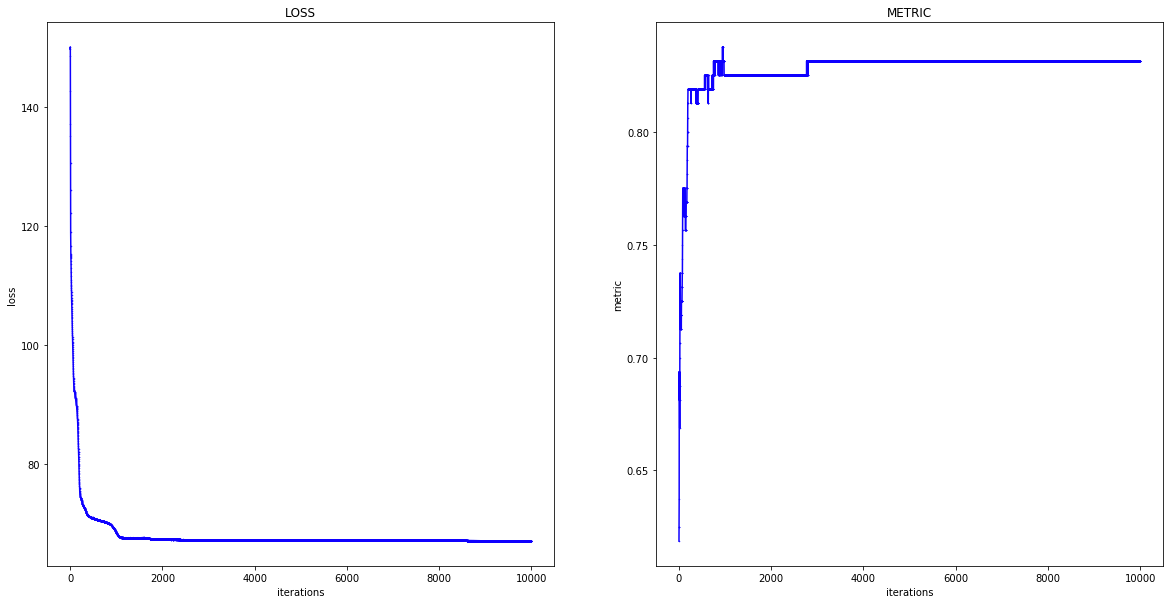

In [15]:
loss = svm.history['loss']
metric = svm.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

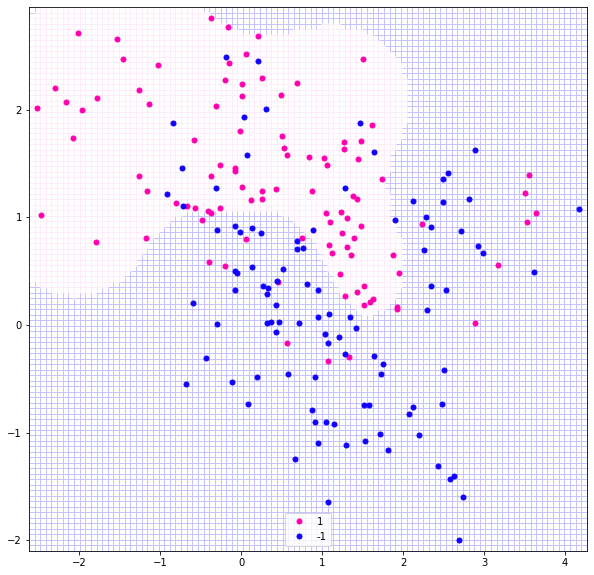

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, np.min(X[:,1])-0.1, np.max(X[:,1])+0.1])
u = np.linspace(np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, 100)
v = np.linspace(np.min(X[:,1])-0.1, np.max(X[:,1])+0.1, 100)
z = []
for i in range(100):
    for j in range(100):
        z.append([u[i], v[j]])
z = np.array(z)
w = svm.predict(z)
svm_pos = np.where(w == 1)[0]
svm_neg = np.where(w == -1)[0]
ax.plot(z[svm_pos,0], z[svm_pos,1], marker='+', color='#FFECFB', markersize=10, linestyle='')
ax.plot(z[svm_neg,0], z[svm_neg,1], marker='+', color='#C7C3FF', markersize=10, linestyle='')
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == -1)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='-1')
ax.legend()